In [3]:
import os
os.chdir('..')

In [5]:
from cem_optimizer_v2 import CEM_opt
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from queue import Queue
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import torch


In [6]:
env_name = 'plate-slide-side-v2-goal-observable'
env_cls = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[env_name]
env_planner = env_cls()
env_test = env_cls()

env_action_space_shape = env_test.action_space.shape[0]
env_obs_space_shape = env_test.observation_space.shape[0]

/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
class InformedPlanner:
    
    def __init__(self, env):
        
        self.env = env
        self.horizon = 20
        self.num_sequence_action = 100
        self.cem = CEM_opt(num_action_seq=self.num_sequence_action,
                           action_seq_len=env_action_space_shape * self.horizon,
                           percent_elite=0.1)
        self.action_seq_planned = Queue(maxsize=self.horizon)
        
        
    def plan(self, force_replan=False):
        
        if self.action_seq_planned.empty() or force_replan:
            
            action_sequences = self.cem.population
            rewards = np.zeros(action_sequences.shape[0])
            for idx, seq in enumerate(action_sequences):
                rewards[idx] = self.eval_act_seq(seq)
            self.cem.update(rewards)
            
            for act in self.cem.solutions().reshape(-1, 4):
                self.action_seq_planned.put(act)
        return self.action_seq_planned.get()
            
            
                    
    def eval_act_seq(self, sequence):
        rew_seq = 0
        self.env.reset()
        act_reshaped = sequence.reshape((-1, 4))
        for act in act_reshaped:
            
            _, r, _, _ = self.env.step(act)
            rew_seq += r
        return rew_seq/len(sequence)

planner = InformedPlanner(env_planner)
planner.plan()

array([-0.31032942,  0.12199124, -0.36915998, -0.05524571])

In [8]:
planner = InformedPlanner(env_planner)

TOT_avg_rew = []
TOT_avg_rew.append(0)
TOT_avg_rew.append(0)

for ep in range(100):
    
    env_test.reset()

    r_for_ep = 0
    for h in range(100):
        act = planner.plan()
        s_prime, r, done, _ = env_test.step(act)
        r_for_ep += r
        if r==10.0:
            done= True
            print(f"SOLVED IN {ep} iteration")
            break 
        print(f'episode {ep}, step {h}, reward  {r} | done? {done}')
    if done == True: break
    
    TOT_avg_rew.append(r_for_ep)
    print(f'prev avg rew {TOT_avg_rew[-2]}, actual avg rew {TOT_avg_rew[-1]}')
    clear_output(wait=True)

        

episode 33, step 0, reward  0.2040110274358461 | done? False
episode 33, step 1, reward  0.21432138720423108 | done? False
episode 33, step 2, reward  0.2319867182553324 | done? False
episode 33, step 3, reward  0.2580344032236253 | done? False
episode 33, step 4, reward  0.29521816694838987 | done? False
episode 33, step 5, reward  0.34796341242180806 | done? False
episode 33, step 6, reward  0.422493763604744 | done? False
episode 33, step 7, reward  0.5266341917440482 | done? False
episode 33, step 8, reward  0.6691469021324876 | done? False
episode 33, step 9, reward  0.8566064102423416 | done? False
episode 33, step 10, reward  1.0758635621982764 | done? False
episode 33, step 11, reward  1.2776213492646429 | done? False
episode 33, step 12, reward  1.4305640196520748 | done? False
episode 33, step 13, reward  1.4991005594811402 | done? False
episode 33, step 14, reward  1.5 | done? False
episode 33, step 15, reward  1.5 | done? False
episode 33, step 16, reward  1.5 | done? False

KeyboardInterrupt: 

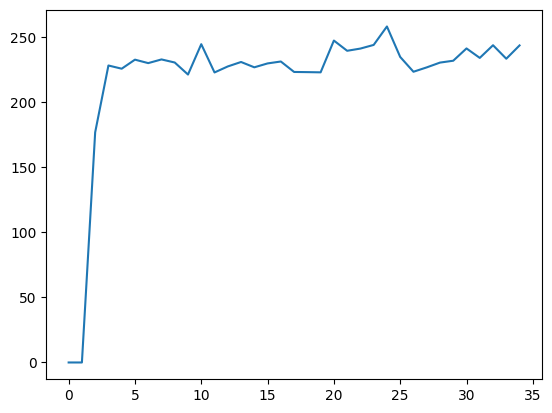

In [9]:
plt.plot(TOT_avg_rew)

In [12]:
planner.plan()


array([-0.32953843, -0.2710788 , -0.89920303,  0.13839272])

In [13]:
planner = InformedPlanner(env_planner)

acts_to_exec = planner.plan()
acts_to_exec = acts_to_exec.reshape((-1, 4))

In [ ]:
import time

In [ ]:
env_test.reset()

for idx, a in enumerate(acts_to_exec):
    if idx == 0:
        time.sleep(0.3)
    time.sleep(0.01)
    env_test.render()
    env_test.step(a)
env_test.close()